# Fermi-Hubbard Model

In [447]:
using Pkg; Pkg.activate()
using KadanoffBaym
using LinearAlgebra, BlockArrays
using UnPack
using JLD

  Activating environment at `~/.julia/environments/v1.6/Project.toml`


In [448]:
using PyPlot
PyPlot.plt.style.use("./paper.mplstyle")

## Model

Second-order Born approximation:
$$
    \Sigma_{ij, \uparrow}  (t, t') = U^2 G_{ij, \uparrow}(t, t') G_{ij, \downarrow}(t, t') G_{ji, \downarrow}(t', t),\\
    \Sigma_{ij, \downarrow}(t, t') = U^2 G_{ij, \downarrow}(t, t') G_{ij, \uparrow}(t, t') G_{ji, \uparrow}(t', t)
$$


$T$-matrix approximation:
$$
    \Sigma_{ij, \uparrow}  (t, t') = U^2 T_{ij}(t, t') G_{ji, \downarrow}(t', t),\\
    \Sigma_{ij, \downarrow}(t, t') = U^2 T_{ij}(t, t') G_{ji, \uparrow}(t', t)
$$

$$
   T_{ij}(t, t') =  G_{ij, \uparrow}(t, t') G_{ij, \downarrow}(t, t') + U \int_{\mathcal{C}}\mathrm{d}s\; G_{ij, \uparrow}(t, s) G_{ij, \downarrow}(t, s) T_{ij}(s, t')
$$

$t<t'$:
$$
    \int_{\mathcal{C}}\mathrm{d}s\; A(t, s) B(s, t') = \int_{t_0}^{t}{\mathrm{d}\bar{t}}  A^>(t, \bar{t}) B^<(\bar{t}, t') + \int_{t}^{t'}{\mathrm{d}\bar{t}}  A^<(t, \bar{t}) B^<(\bar{t}, t') + \int_{t'}^{t_0}{\mathrm{d}\bar{t}}  A^<(t, \bar{t}) B^>(\bar{t}, t')  
$$
$t>t'$:
$$
    \int_{\mathcal{C}}\mathrm{d}s\; A(t, s) B(s, t') = \int_{t_0}^{t'}{\mathrm{d}\bar{t}}  A^>(t, \bar{t}) B^<(\bar{t}, t') + \int_{t'}^{t}{\mathrm{d}\bar{t}}  A^>(t, \bar{t}) B^>(\bar{t}, t') + \int_{t}^{t_0}{\mathrm{d}\bar{t}}  A^<(t, \bar{t}) B^>(\bar{t}, t')  
$$

$$
    T^<_{ij}(t, t') =  G^<_{ij, \uparrow}(t, t') G^<_{ij, \downarrow}(t, t') + U \int_{t_0}^{t}{\mathrm{d}\bar{t}}\; G^>_{ij, \uparrow}(t, s) G^>_{ij, \downarrow}(t, s) T^<_{ij}(s, t') + U \int_{t}^{t'}{\mathrm{d}\bar{t}}\; G^<_{ij, \uparrow}(t, s) G^<_{ij, \downarrow}(t, s) T^<_{ij}(s, t') + U \int_{t'}^{t_0}{\mathrm{d}\bar{t}}\; G^<_{ij, \uparrow}(t, s) G^<_{ij, \downarrow}(t, s) T^>_{ij}(s, t')
$$

$$
    T^>_{ij}(t, t') =  G^>_{ij, \uparrow}(t, t') G^>_{ij, \downarrow}(t, t') + U \int_{t_0}^{t'}{\mathrm{d}\bar{t}}\; G^>_{ij, \uparrow}(t, s) G^>_{ij, \downarrow}(t, s) T^<_{ij}(s, t') + U \int_{t'}^{t}{\mathrm{d}\bar{t}}\; G^>_{ij, \uparrow}(t, s) G^>_{ij, \downarrow}(t, s) T^>_{ij}(s, t') + U \int_{t}^{t_0}{\mathrm{d}\bar{t}}\; G^<_{ij, \uparrow}(t, s) G^<_{ij, \downarrow}(t, s) T^>_{ij}(s, t')
$$

$$
    \dot{T}^<_{ij}(t, t') = \partial_t\left(G^<_{ij, \uparrow}(t, t') G^<_{ij, \downarrow}(t, t')\right) + U G^>_{ij, \uparrow}(t, t) G^>_{ij, \downarrow}(t, t) T^<_{ij}(t, t') - U G^<_{ij, \uparrow}(t, t) G^<_{ij, \downarrow}(t, t) T^<_{ij}(t, t') \\
    + U \int_{t_0}^{t}{\mathrm{d}\bar{t}}\; \partial_t\left(G^>_{ij, \uparrow}(t, t') G^>_{ij, \downarrow}(t, t')\right) T^<_{ij}(s, t') + U \int_{t}^{t'}{\mathrm{d}\bar{t}}\; \partial_t\left(G^<_{ij, \uparrow}(t, t') G^<_{ij, \downarrow}(t, t')\right) T^<_{ij}(s, t') + U \int_{t'}^{t_0}{\mathrm{d}\bar{t}}\; \partial_t\left(G^<_{ij, \uparrow}(t, t') G^<_{ij, \downarrow}(t, t')\right) T^>_{ij}(s, t')
$$

$$
    \dot{T}^>_{ij}(t, t') = \partial_t\left(G^>_{ij, \uparrow}(t, t') G^>_{ij, \downarrow}(t, t')\right) + U G^>_{ij, \uparrow}(t, t) G^>_{ij, \downarrow}(t, t) T^>_{ij}(t, t') - U G^<_{ij, \uparrow}(t, t) G^<_{ij, \downarrow}(t, t) T^>_{ij}(t, t') \\
    + U \int_{t_0}^{t'}{\mathrm{d}\bar{t}}\; \partial_t\left(G^>_{ij, \uparrow}(t, s) G^>_{ij, \downarrow}(t, s)\right) T^<_{ij}(s, t') + U \int_{t'}^{t}{\mathrm{d}\bar{t}}\; \partial_t\left(G^>_{ij, \uparrow}(t, s) G^>_{ij, \downarrow}(t, s)\right) T^<_{ij}(s, t') + U \int_{t}^{t_0}{\mathrm{d}\bar{t}}\; \partial_t\left(G^<_{ij, \uparrow}(t, s) G^<_{ij, \downarrow}(t, s)\right) T^>_{ij}(s, t')
$$

## Solving

In [449]:
num_sites = 2;

In [450]:
# 8-site 3D cubic lattice
h = BlockArray{ComplexF64}(undef_blocks, [4, 4], [4, 4])
diag_block = [0 -1 0 -1; -1 0 -1 0; 0 -1 0 -1; -1 0 -1 0]
setblock!(h, diag_block, 1, 1)
setblock!(h, diag_block, 2, 2)
setblock!(h, Diagonal(-1 .* ones(4)), 1, 2)
setblock!(h, Diagonal(-1 .* ones(4)), 2, 1)

full_h = BlockArray{ComplexF64}(undef_blocks, [8, 8], [8, 8])
setblock!(full_h, h |> Array, 1, 1)
setblock!(full_h, h |> Array, 2, 2)
setblock!(full_h, zeros(ComplexF64, 8, 8), 1, 2)
setblock!(full_h, zeros(ComplexF64, 8, 8), 2, 1)

full_h = full_h |> Array;

In [451]:
Base.@kwdef struct FermiHubbardModel
    U::Float64
    H = ComplexF64[0 -1 0 0; -1 0 0 0; 0 0 0 -1; 0 0 -1 0] # two-site 1D chain
    
    # 8-site 3D cubic lattice
#     H = full_h
end

FermiHubbardModel

In [452]:
struct FermiHubbardData{T, S}
    GL::T
    GG::T
    FL::T
    FG::T
    
    TL::S
    TG::S    
    
    ΣNCA_c_L::T
    ΣNCA_c_G::T
    ΣNCA_f_L::T
    ΣNCA_f_G::T
    
    dot_GL_GL::S
    dot_GG_GG::S
    
    # Initialize problem
    function FermiHubbardData(GL::T, GG::T, FL::T, FG::T, TL::S, TG::S) where {T, S}
        new{T, S}(GL, GG, FL, FG, zero(TL), zero(TG), zero(GL), zero(GG), zero(FL), zero(FG), zero(TL), zero(TG))
    end
end

In [453]:
# struct FermiHubbardData{T}
#     GL::T
#     GG::T
#     FL::T
#     FG::T

#     ΣNCA_c_L::T
#     ΣNCA_c_G::T
#     ΣNCA_f_L::T
#     ΣNCA_f_G::T

#     # Initialize problem
#     function FermiHubbardData(GL::T, GG::T, FL::T, FG::T) where {T}
#         new{T}(GL, GG, FL, FG, zero(GL), zero(GG), zero(FL), zero(FG))
#     end
# end

In [514]:
function fv!(model, data, out, times, t, t′)
    @unpack GL, GG, FL, FG, TL, TG, ΣNCA_c_L, ΣNCA_c_G, ΣNCA_f_L, ΣNCA_f_G, dot_GL_GL, dot_GG_GG = data
    @unpack H, U = model 

    if (n = size(GL, 3)) > size(dot_GL_GL, 3)
        resize!(dot_GL_GL, n)
        resize!(dot_GG_GG, n)
    end    
    
    # real-time collision integral
    ∫dt(i, j, A, B) =
        sign(j - i) * integrate(times[min(i, j):max(i, j)],[A[t, s] * B[s, t′] for s = min(i, j):max(i, j)])
    
    ∫dt_(i, j, A, B) =
        sign(j - i) * integrate(times[min(i, j):max(i, j)],[A[t, s] .* B[s, t′] for s = min(i, j):max(i, j)])    
    
    ΣHF_c(t, t′) = 1.0im * U * Diagonal([FL[k, k, t, t] for k in 1:num_sites])
    ΣHF_f(t, t′) = 1.0im * U * Diagonal([GL[k, k, t, t] for k in 1:num_sites])
    
    rhs_c_L = -1.0im * ((H[1:num_sites, 1:num_sites] + ΣHF_c(t, t′)) * GL[t, t′] + 
            ∫dt(1, t, ΣNCA_c_G, GL) + ∫dt(t, t′, ΣNCA_c_L, GL) - ∫dt(1, t′, ΣNCA_c_L, GG)
        )

    rhs_c_G = -1.0im * ((H[1:num_sites, 1:num_sites] + ΣHF_c(t, t′)) * GG[t, t′] + 
            ∫dt(t′, t, ΣNCA_c_G, GG) - ∫dt(1, t, ΣNCA_c_L, GG) + ∫dt(1, t′, ΣNCA_c_G, GL)
        )

    rhs_f_L = -1.0im * ((H[1 + num_sites:2 * num_sites, 1 + num_sites:2 * num_sites] + ΣHF_f(t, t′)) * FL[t, t′] + 
            ∫dt(1, t, ΣNCA_f_G, FL) + ∫dt(t, t′, ΣNCA_f_L, FL) - ∫dt(1, t′, ΣNCA_f_L, FG)
        )

    rhs_f_G = -1.0im * ((H[1 + num_sites:2 * num_sites, 1 + num_sites:2 * num_sites] + ΣHF_f(t, t′)) * FG[t, t′] +
            ∫dt(t′, t, ΣNCA_f_G, FG) - ∫dt(1, t, ΣNCA_f_L, FG) + ∫dt(1, t′, ΣNCA_f_G, FL)
        )    
    
    out[1] = rhs_c_L
    out[2] = rhs_c_G
    out[3] = rhs_f_L
    out[4] = rhs_f_G
    
    out[5] = (dot_GL_GL[t, t′]
              + U .* (FG[t, t] .* GG[t, t] - FL[t, t] .* GL[t, t]) .* TL[t, t′]
#               + U .* (∫dt_(1, t, dot_GG_GG, TL) + ∫dt_(t, t′, dot_GL_GL, TL) - ∫dt_(1, t′, dot_GL_GL, TG))
             )
    
    out[6] = (dot_GG_GG[t, t′]
              + U .* (FG[t, t] .* GG[t, t] - FL[t, t] .* GL[t, t]) .* TG[t, t′]
#               + U .* (∫dt_(t′, t, dot_GG_GG, TG) - ∫dt_(1, t, dot_GL_GL, TG) + ∫dt_(1, t′, dot_GG_GG, TL))
             )
    
#     @show out[5]
#     @show out[6]
end

function fd!(model, data, out, times, t, t′)
    fv!(model, data, out, times, t, t)
    out[1:4] .-= adjoint.(out[1:4])
    out[5:6] .+= adjoint.(out[5:6])
end

fd! (generic function with 1 method)

In [530]:
myout = [data.GL[1,1], data.GG[1,1], data.FL[1,1], data.FG[1,1], data.TL[1,1], data.TG[1,1]]

function self_energies!(model, data, times, t, t′)
    @unpack GL, GG, FL, FG, TL, TG, ΣNCA_c_L, ΣNCA_c_G, ΣNCA_f_L, ΣNCA_f_G, dot_GL_GL, dot_GG_GG = data
    @unpack U = model

    if (n = size(GL, 3)) > size(ΣNCA_c_L, 3)
        resize!(ΣNCA_c_L, n)
        resize!(ΣNCA_c_G, n)
        resize!(ΣNCA_f_L, n)
        resize!(ΣNCA_f_G, n)
    end
    
    fv!(model, data, myout, times, t, t′)
    if t == t′
        myout .-= adjoint.(myout)
    end
    
    dot_GL_GL[t, t′] = (myout[1] .* FL[t, t′] .+ GL[t, t′] .* myout[3])
    dot_GG_GG[t, t′] = (myout[2] .* FG[t, t′] .+ GG[t, t′] .* myout[4])
    
#     TL[t, t′] = GL[t, t′] .* FL[t, t′]
#     TG[t, t′] = GG[t, t′] .* FG[t, t′]
    
    ΣNCA_c_L[t, t′] = U^2 .* TL[t, t′] .* transpose(FG[t′, t])
    ΣNCA_f_L[t, t′] = U^2 .* TL[t, t′] .* transpose(GG[t′, t])
    
    ΣNCA_c_G[t, t′] = U^2 .* TG[t, t′] .* transpose(FL[t′, t])
    ΣNCA_f_G[t, t′] = U^2 .* TG[t, t′] .* transpose(GL[t′, t])
end

self_energies! (generic function with 1 method)

In [531]:
# quantum numbers
dim = num_sites

# Define your Green functions at (t0, t0) – time arguments at the end
GL = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), SkewHermitian)
GG = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), SkewHermitian)
FL = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), SkewHermitian)
FG = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), SkewHermitian)

TL = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), Symmetrical)
TG = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), Symmetrical)

# Initial condition
N_c = zeros(num_sites)
N_f = zeros(num_sites)
N_c[1] = 0.5
# N_c[1:4] = [0.7, 0.0, 0.7, 0.0]
# N_f[1:4] = [0.0, 0.25, 0.0, 0.25]

# N_c[5:8] = [0.0, 0.4, 0.0, 0.4]
# N_f[5:8] = [0.65, 0.0, 0.65, 0.0]

GL[1, 1] = 1.0im * diagm(N_c)
GG[1, 1] = -1.0im * (I - diagm(N_c))
FL[1, 1] = 1.0im * diagm(N_f)
FG[1, 1] = -1.0im * (I - diagm(N_f))

data = FermiHubbardData(GL, GG, FL, FG, TL, TG)
model = FermiHubbardModel(U = 0.25)
# model = FermiHubbardModel(U = 1.)

data.TL[1, 1] = GL[1, 1] .* FL[1, 1]
data.TG[1, 1] = GG[1, 1] .* FG[1, 1]

tmax = 2;

In [532]:
function integrate(x::AbstractVector, y::AbstractVector)
    if isone(length(x))
        return zero(first(y))
    end

    @inbounds retval = (x[2] - x[1]) * (y[1] + y[2])
    @inbounds @fastmath @simd for i = 2:(length(y)-1)
        retval += (x[i+1] - x[i]) * (y[i] + y[i+1])
    end
    return 1 // 2 * retval
end;

In [533]:
atol = 1e-6
rtol = 1e-4;

# atol = 1e-5
# rtol = 1e-3;

In [534]:
@time sol = kbsolve!(
    (x...) -> fv!(model, data, x...),
    (x...) -> begin
        println(" t: $(x[2][x[3]])")
        fd!(model, data, x...)
    end,
    [data.GL, data.GG, data.FL, data.FG, data.TL, data.TG],
    (0.0, tmax);
    callback = (x...) -> self_energies!(model, data, x...),
    atol = atol,
    rtol = rtol,
    dtini=1e-4
);

 t: 0.0
 t: 0.0001
 t: 0.0001
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN
 t: NaN


LoadError: InexactError: trunc(Int64, NaN)

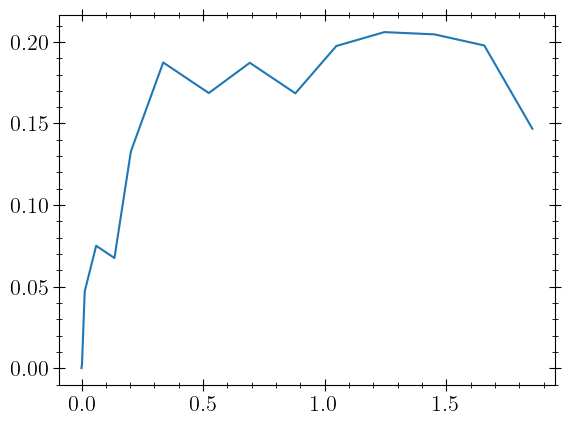

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff769a3e070>

In [507]:
plot(sol.t[1:end-1], sol.t |> diff)

In [508]:
# save("FH_1D_sol_U_"*string(model.U)*"_atol_1e-8_rtol_1e-6.jld", "solution", sol)
save("FH_3D_T_matrix_sol_U_"*string(model.U)*"_tmax_"*string(tmax)*"_atol_"*string(atol)*"_rtol_"*string(rtol)*".jld", "solution", sol)

## Example plots

### Load data

In [509]:
# loaded_sol = load("FH_1D_sol_U_0.5_atol_1e-8_rtol_1e-6.jld")
loaded_sol = load("FH_3D_T_matrix_sol_U_"*string(model.U)*"_tmax_"*string(tmax)*"_atol_"*string(atol)*"_rtol_"*string(rtol)*".jld")

# U_0_sol = load("FH_sol_U_0.0_atol_1e-8_rtol_1e-6.jld");

In [510]:
num_points = (loaded_sol["solution"].t |> size)[1]

19

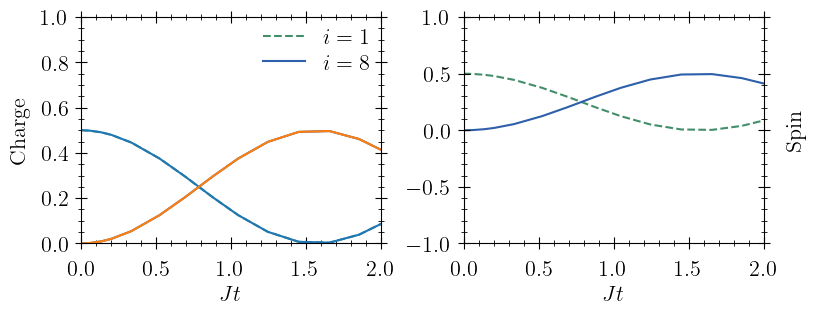

In [511]:
xpad = 8
ypad = 5

figure(figsize = (8, 3))

ax = subplot(121)
idx_1 = 1
idx_2 = 2

plot(loaded_sol["solution"].t, [imag(loaded_sol["solution"].u[1][idx_1, idx_1, k, k] .+ loaded_sol["solution"].u[3][idx_1, idx_1, k, k]) for k = 1:num_points], 
    label = "\$ i=1\$", lw=1.5, ls = "--", c = "#438E6A")

plot(loaded_sol["solution"].t, [imag(loaded_sol["solution"].u[1][idx_2, idx_2, k, k] .+ loaded_sol["solution"].u[3][idx_2, idx_2, k, k]) for k = 1:num_points], 
    label = "\$ i=8\$", lw=1.5, ls = "-", c = "#2D5FAA")

idx_1 = 1
idx_2 = 2

plot(loaded_sol["solution"].t, [imag(loaded_sol["solution"].u[1][idx_1, idx_1, k, k] .+ loaded_sol["solution"].u[3][idx_1, idx_1, k, k]) for k = 1:num_points]) 

plot(loaded_sol["solution"].t, [imag(loaded_sol["solution"].u[1][idx_2, idx_2, k, k] .+ loaded_sol["solution"].u[3][idx_2, idx_2, k, k]) for k = 1:num_points]) 


idx_1 = 1
idx_2 = 2


xlim(0, tmax)
# ax.set_xticks([0, 8, 16, 24, 32])
ylim(-0, 1)
xlabel("\$J t\$")
# ylabel("\$\\mathrm{Im}\\; G^<_{11, \\sigma}(t, t)\$")
ylabel("Charge", labelpad = 8)
ax.xaxis.set_tick_params(pad = xpad)
ax.yaxis.set_tick_params(pad = ypad)
# ax.set_axisbelow(false)
# ticklabel_format(axis = "y", style = "sci", scilimits = (-0, 0))
ax.legend(loc = "best", handlelength = 1.9, frameon = false, borderpad = 0, labelspacing = 0.25)

ax = subplot(122)

plot(loaded_sol["solution"].t, [imag(loaded_sol["solution"].u[1][idx_1, idx_1, k, k] .- loaded_sol["solution"].u[3][idx_1, idx_1, k, k]) for k = 1:num_points], 
    label = "\$ i=2\$", lw=1.5, ls = "--", c = "#438E6A")

plot(loaded_sol["solution"].t, [imag(loaded_sol["solution"].u[1][idx_2, idx_2, k, k] .- loaded_sol["solution"].u[3][idx_2, idx_2, k, k]) for k = 1:num_points], 
    label = "\$ i=2\$",  lw=1.5, ls = "-", c = "#2D5FAA")

xlim(0, tmax)
ylim(-1, 1)
# ax.set_xticks([0, 8, 16, 24, 32])
# ax.set_yticklabels([])
xlabel("\$J t\$")
ylabel("Spin", labelpad = 16)
ax.xaxis.set_tick_params(pad = xpad)
ax.yaxis.set_tick_params(pad = ypad)
ax.set_axisbelow(false)
# ticklabel_format(axis = "y", style = "sci", scilimits = (-0, 0))
# ax.legend( loc = "best", handlelength = 1.9, frameon = false, borderpad = 0, labelspacing = 0.25)
ax.yaxis.set_label_position("right")

tight_layout(pad = 0.1, w_pad = 0.5, h_pad = 0)
# savefig("fermi_hubbard_T.pdf")

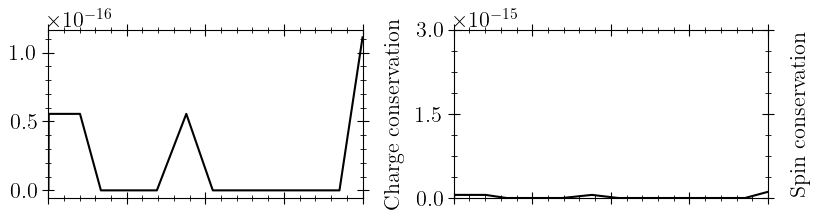

In [512]:
Gs = loaded_sol["solution"]

xpad = 8
ypad = 5

figure(figsize = (8, 2))

ax = subplot(121)
plot(loaded_sol["solution"].t, [(sum(Gs.u[1][i, i, k, k] for i = 1:num_sites) |> imag) .+ (sum(Gs.u[3][i, i, k, k] for i = 1:num_sites) |> imag) for k = 1:num_points] 
    .- sum(N_c .+ N_f)  .|> abs, 
    label = "\$ c \$", ls = "-", c = "k")
xlim(0, tmax)
# ax.set_xticks([0, 8, 16, 24, 32])
ax.set_xticklabels([])
# yticks([k for k in 0:0.5:1] .* 5e-15)
# ylim(0., 0.1)
ylabel("Charge conservation", labelpad = 16)
ax.yaxis.set_label_position("right")

ax = subplot(122)
plot(loaded_sol["solution"].t, [(sum(Gs.u[1][i, i, k, k] for i = 1:num_sites) |> imag) .- (sum(Gs.u[3][i, i, k, k] for i = 1:num_sites) |> imag) for k = 1:num_points] 
    .- sum(N_c .- N_f) .|> abs, 
    label = "\$ c \$", ls = "-", c = "k")
xlim(0, tmax)
# ax.set_xticks([0, 8, 16, 24, 32])
yticks([k for k in 0:0.5:1] .* 3e-15)
ax.set_xticklabels([])
# ax.set_yticklabels([])
ylim([0.0, 1] .* 3e-15)
ylabel("Spin conservation", labelpad = 16)
ax.yaxis.set_label_position("right")

tight_layout(pad = 0.0, w_pad = 0.5, h_pad = 0)
# savefig("fermi_hubbard_example_T_inset.pdf")

In [513]:
using FFTW, Interpolations

In [467]:
idx = 1
ρτ, (τs, ts) = wigner_transform_itp(FG[idx, idx, :, :] - FL[idx, idx, :, :], sol.t, fourier=false);
ρω, (ωs, ts) = wigner_transform_itp(FG[idx, idx, :, :] - FL[idx, idx, :, :], sol.t, fourier=true);

LoadError: DimensionMismatch("knot vectors must have the same axes as the corresponding dimension of the array")

In [468]:
idx = 5
shift = 0
ρτ, (τs, ts) = wigner_transform_itp((loaded_sol["solution"].u[2][idx, idx, :, :] - loaded_sol["solution"].u[1][idx, idx, :, :])[1+shift:end-shift, 1+shift:end-shift], 
    loaded_sol["solution"].t[1+shift:end-shift], fourier=false);
ρω, (ωs, ts) = wigner_transform_itp((loaded_sol["solution"].u[2][idx, idx, :, :] - loaded_sol["solution"].u[1][idx, idx, :, :])[1+shift:end-shift, 1+shift:end-shift], 
    loaded_sol["solution"].t[1+shift:end-shift], fourier=true);

LoadError: BoundsError: attempt to access 2×2×32×32 Array{ComplexF64, 4} at index [5, 5, 1:32, 1:32]

In [469]:
τs |> size

(32,)

In [470]:
ts |> size

(32,)

In [471]:
t_scale = 1
ω_scale = 1;

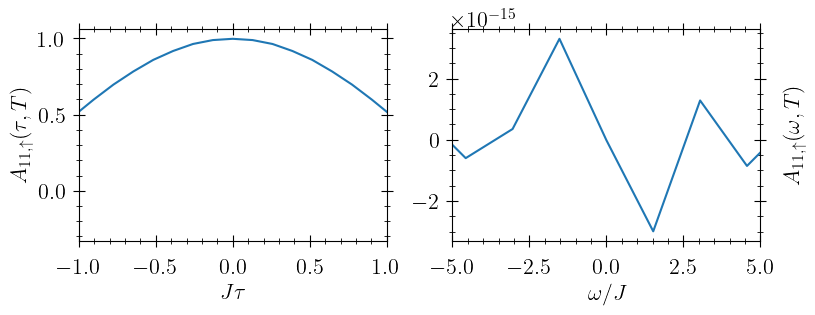

16

In [472]:
xpad = 8
ypad = 5

center = floor(length(ts) / 2) |> Int
center |> print

figure(figsize=(8, 3))

ax = subplot(121)
plot(t_scale * τs, -ρτ[:, center] |> imag, ls="-", c="C0", lw=1.5)
ax.set_xlabel("\$J \\tau\$")
ax.set_xlim(-t_scale * tmax / 2, t_scale * tmax / 2)
# ax.set_ylim(-0.6, 1.0)
ax.set_xticks(t_scale .* [-tmax/2, -tmax/4, 0, tmax/4, tmax/2])
ax.xaxis.set_tick_params(pad=xpad)
ax.yaxis.set_tick_params(pad=ypad)
ax.set_ylabel("\$  A_{11, \\uparrow}(\\tau, T) \$")


ax = subplot(122)
plot(ω_scale * ωs, ρω[:, center] |> real, "-", c="C0", lw=1.5)

ax.xaxis.set_tick_params(pad=xpad)
ax.yaxis.set_tick_params(pad=ypad)
ax.set_xlabel("\$\\omega/J\$")
ax.set_ylabel("\$ A_{11,\\uparrow}(\\omega, T)\$", labelpad=16)
ax.set_xlim(5 .* (-1, 1))
# ax.set_ylim(0, 10)
ax.yaxis.set_label_position("right")
# ax.legend(loc="best", handlelength=1.4, frameon=false, borderpad=0, labelspacing=0.25)

tight_layout(pad=0.1, w_pad=0.5, h_pad=0)


# savefig("fermi_hubbard_example_tau_omega.pdf")

In [473]:
function meshgrid(xin,yin)
  nx=length(xin)
  ny=length(yin)
  xout=zeros(ny,nx)
  yout=zeros(ny,nx)
  for jx=1:nx
      for ix=1:ny
          xout[ix,jx]=xin[jx]
          yout[ix,jx]=yin[ix]
      end
  end
  return (x=xout, y=yout)
end

Y, X = meshgrid(loaded_sol["solution"].t, loaded_sol["solution"].t);

In [474]:
Y_gauss, X_gauss = meshgrid(U_0_sol["solution"].t, U_0_sol["solution"].t)
GL_gauss = U_0_sol["solution"].u[1]
GG_gauss = U_0_sol["solution"].u[2];

LoadError: UndefVarError: U_0_sol not defined

In [475]:
cmap = "gist_heat";

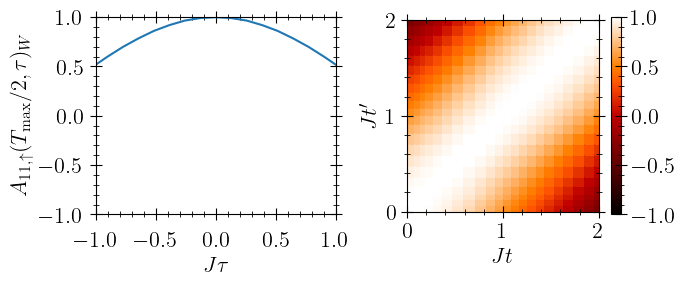

16

In [476]:
figure(figsize=(7, 3))
t_scale = 1
vmin = -1.0
vmax = 1.0

# ax = subplot(121) # plt.gca()
# heatmap = ax.pcolormesh(X_gauss, Y_gauss, imag(GL_gauss.data[1, 1, :, :]) .- imag(GG_gauss.data[1, 1, :, :]), cmap=cmap, rasterized=true, vmin=vmin, vmax=vmax)
# heatmap.set_edgecolor("face")
# ax.set_aspect("equal")
# # cbar = colorbar(mappable=heatmap)
# # cbar.formatter.set_powerlimits((0, 0))
# ax.set_xlabel("\$J t\$")
# ax.set_ylabel("\$J t'\$")
# ax.set_xlim(0, t_scale * tmax)
# ax.set_ylim(0, t_scale * tmax)
# ax.set_xticks(t_scale .* [0, tmax/2, tmax])
# ax.set_yticks(t_scale .* [0, tmax/2, tmax])

center = floor(length(ts) / 2) |> Int
center |> print


ax = subplot(121)
plot(t_scale * τs, -ρτ[:, center] |> imag, ls="-", c="C0", lw=1.5)
ax.set_xlabel("\$J \\tau\$")
ax.set_xlim(-t_scale * tmax / 2, t_scale * tmax / 2)
ax.set_ylim(-1, 1)
ax.set_xticks(t_scale .* [-tmax/2, -tmax/4, 0, tmax/4, tmax/2])
ax.xaxis.set_tick_params(pad=xpad)
ax.yaxis.set_tick_params(pad=ypad)
ax.set_ylabel("\$  A_{11, \\uparrow}(T_{\\mathrm{max}}/2, \\tau)_W \$")

ax = subplot(122)
heatmap = ax.pcolormesh(X, Y, imag(loaded_sol["solution"].u[1][1, 1, :, :]) .- imag(loaded_sol["solution"].u[2][1, 1, :, :]), cmap=cmap, rasterized=true, vmin=vmin, vmax=vmax)
heatmap.set_edgecolor("face")
ax.set_aspect("equal")
cbar = colorbar(mappable=heatmap)
cbar.formatter.set_powerlimits((0, 0))
ax.set_xlabel("\$J t\$")
ax.set_ylabel("\$J t'\$")
ax.set_xlim(0, t_scale * tmax)
ax.set_ylim(0, t_scale * tmax)
ax.set_xticks(t_scale .* [0, tmax/2, tmax])
ax.set_yticks(t_scale .* [0, tmax/2, tmax])
# ax.set_yticklabels([])

tight_layout(pad=0.75, w_pad=0.5, h_pad=0)

# savefig("fermi_hubbard_example_two_times.pdf")

## Testing

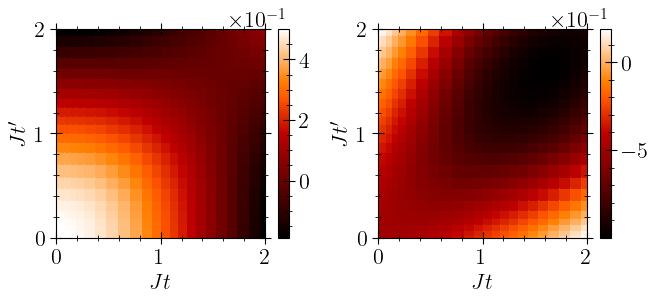

In [477]:
figure(figsize=(7, 3))
t_scale = 1
# vmin = -1.0
# vmax = 1.0

ax = subplot(121)
heatmap = ax.pcolormesh(X, Y, imag(loaded_sol["solution"].u[1][1, 1, :, :]), cmap=cmap, rasterized=true)#, vmin=vmin, vmax=vmax)
heatmap.set_edgecolor("face")
ax.set_aspect("equal")
cbar = colorbar(mappable=heatmap)
cbar.formatter.set_powerlimits((0, 0))
ax.set_xlabel("\$J t\$")
ax.set_ylabel("\$J t'\$")
ax.set_xlim(0, t_scale * tmax)
ax.set_ylim(0, t_scale * tmax)
ax.set_xticks(t_scale .* [0, tmax/2, tmax])
ax.set_yticks(t_scale .* [0, tmax/2, tmax])

ax = subplot(122)
heatmap = ax.pcolormesh(X, Y, imag(loaded_sol["solution"].u[2][1, 1, :, :]), cmap=cmap, rasterized=true)#, vmin=vmin, vmax=vmax)
heatmap.set_edgecolor("face")
ax.set_aspect("equal")
cbar = colorbar(mappable=heatmap)
cbar.formatter.set_powerlimits((0, 0))
ax.set_xlabel("\$J t\$")
ax.set_ylabel("\$J t'\$")
ax.set_xlim(0, t_scale * tmax)
ax.set_ylim(0, t_scale * tmax)
ax.set_xticks(t_scale .* [0, tmax/2, tmax])
ax.set_yticks(t_scale .* [0, tmax/2, tmax])
# ax.set_yticklabels([])

tight_layout(pad=0.75, w_pad=0.5, h_pad=0)